In [436]:
%matplotlib inline
%load_ext rpy2.ipython
import os
import scipy

GIMME_DIR = "/home/isaac/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "simout/")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import sys
import ast
import math
import subprocess
from scipy.stats import expon

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Define the function to draw the plots

In [2]:
def plot_per_lambda(lambda_dists):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
    axarr = [a for b in axarr for a in b]


    for k, ax in zip(sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k))
        coltimes = lambda_dists[k]
        ax.hist(coltimes)
        ax.set_ylabel('N Species', color='b')
        ax.set_xlabel('Colonization Time', color='b')
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ## Super annoying
        #ax.get_xaxis().set_ticks(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5)))
        #ax.set_xticklabels(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/6)))#, fontsize=7)
        data = sorted(coltimes)
        loc, sc = expon.fit(data, floc=0)
        print("{} {}".format(k, sc))
        rv = expon(scale=sc)
        x = np.linspace(0, max(data), 100)

        ax1 = ax.twinx()
        ax1.plot(x, rv.pdf(x), color='black')
        ax1.get_yaxis().set_ticks([])
    plt.tight_layout()

In [382]:
def plot_pidxy_per_lambda(lambda_dists, xaxis_label, dpi=300, ylabel="N Species", nbins=10, zoom_x=5, \
                          normed=True, sharex=True, sharey=False, semilogy=False, semilogx=False, do_expon=True):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=dpi, sharex=sharex, sharey=sharey)
    if semilogy == True:
        plt.yscale('log', nonposy='clip', log=10)
    if semilogx == True:
        plt.xscale('log', nonposy='clip', log=10)
    axarr = [a for b in axarr for a in b]


    for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k))
        coltimes = lambda_dists[k]
        ax.hist(coltimes, color="red", bins=nbins, normed=normed)
        if i in [0, 3]:
            ax.set_ylabel(ylabel)
            #ax.get_yaxis().set_ticks([])
        if i in [3, 4, 5]:
            ax.set_xlabel(xaxis_label)
            #ax.get_xaxis().set_ticks([])

        x0, x1 = ax.get_xlim()
        ax.set_xlim(0, x1/zoom_x)
        ## Super annoying
        #ax.get_xaxis().set_ticks(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5)))
        #ax.set_xticklabels(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/6)))#, fontsize=7)

        if do_expon:
            data = sorted(coltimes)
            loc, sc = expon.fit(data, floc=0)
            ## Don't print the scaling factor
            print("{} {}".format(k, sc))
            rv = expon(scale=sc)
            x = np.linspace(0, max(data), 100)
            ax1 = ax.twinx()
            ax1.plot(x, rv.pdf(x), color='black')
            ax1.get_yaxis().set_ticks([])
            ax1.set_xlim(xmin=0)
            ax1.set_ylim(ymin=0)
            x0, x1 = ax.get_xlim()
            ax.set_xlim(0, x1/zoom_x)

        
    plt.tight_layout()

0.05 3962.28671875
0.1 7005.89140625
0.25 13675.8101563
0.5 25914.6576512
0.75 48258.958344
1 148812.507854


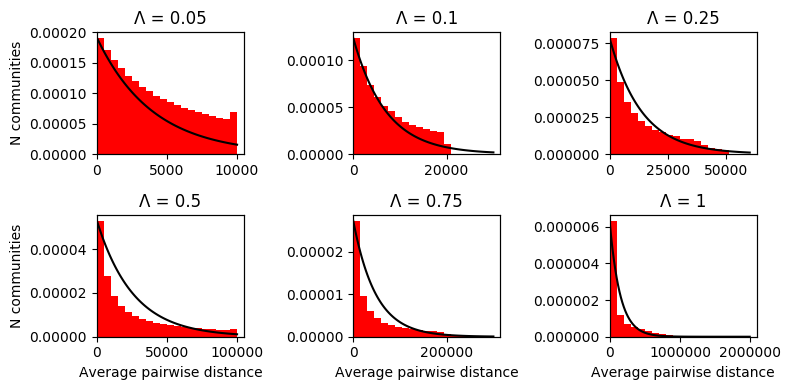

In [387]:

plot_pidxy_per_lambda(lambda_dists, "Average pairwise distance", ylabel="N communities", dpi=100, nbins=20, zoom_x=1, normed=True, sharex=False, sharey=False)

# **Colonization times**
## Gather all the colonization time vectors for all the simulations

In [380]:
files = glob.glob(SIMOUT_DIR + "*5000*/coltimes.txt")
dat = []
for f in files:
    lines = open(f).readlines()
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = [float(x.translate(None, "[],")) for x in line.strip().split()]
            ## Convert colonization time, which is recorded as the timestep of 
            ## colonization, to absolute time, basically subtract each coltime
            ## per species from the "current" time
            l = [l[0]] + [l[1] - x for x in l[2:]]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 27712


## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

Got n coltimes per lambda:
0.25 - 194000	0.5 - 194000	0.05 - 194000	0.1 - 194000	1 - 194000	0.75 - 194000	

0.05 3962.28671875
0.1 7005.89140625
0.25 13675.8101563
0.5 25914.6576512
0.75 48258.958344
1 148812.507854


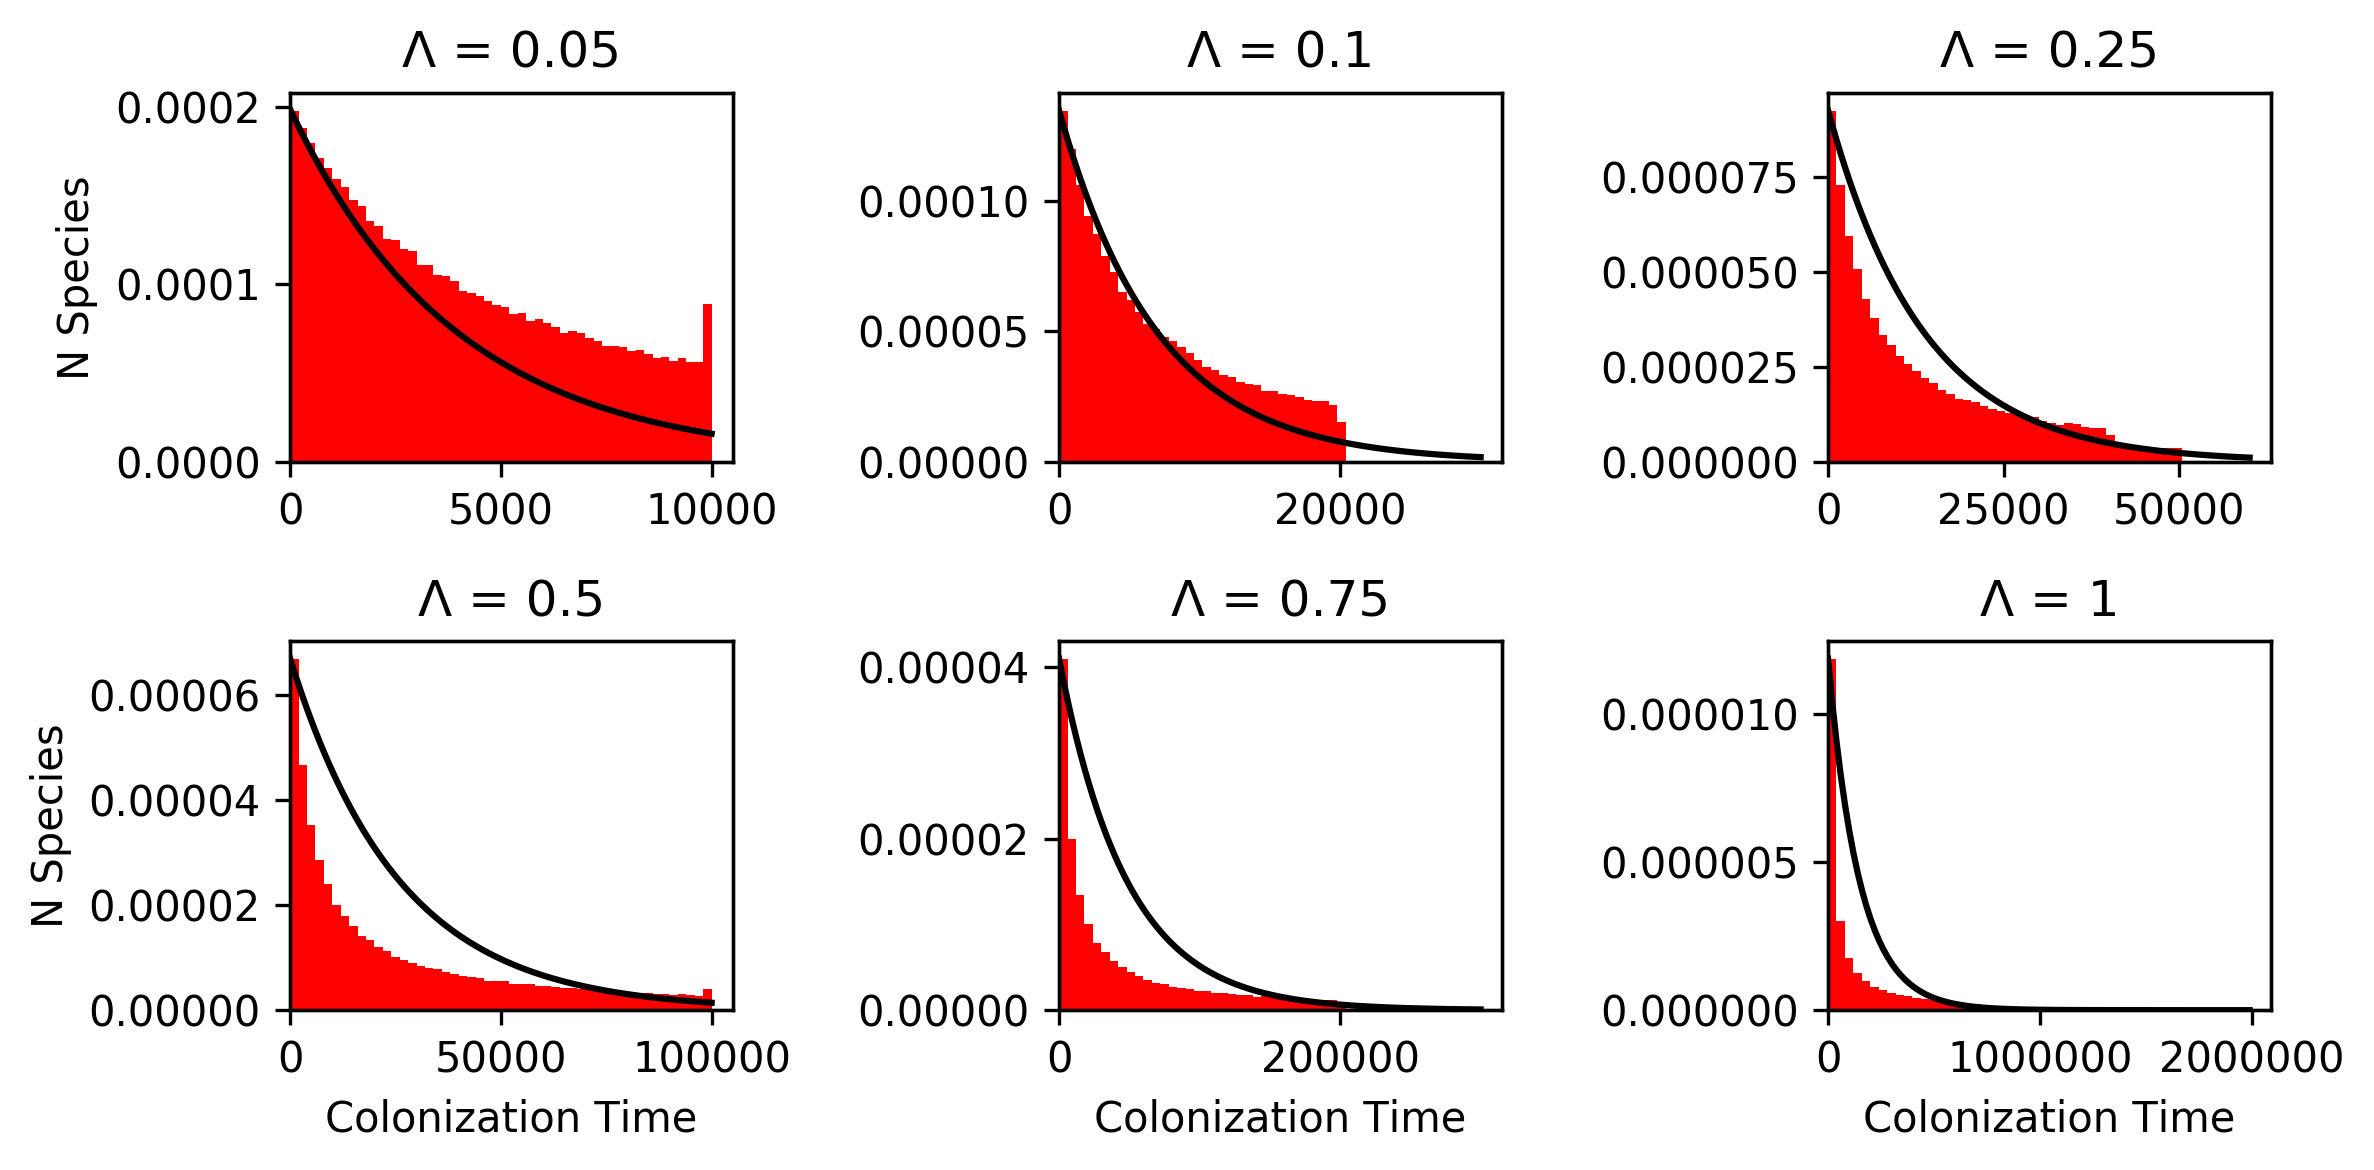

In [391]:
time_tolerance = 0.03
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[2:])
    lambda_dists[percent] = coltimes[:194000]
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),
print("\n")
## Plot
plot_pidxy_per_lambda(lambda_dists, "Colonization Time", nbins=50, normed=True, sharey=False, sharex=False, zoom_x=1, do_expon=True)

# abundances

In [197]:
def unpack_abundances(my_abund):
    """ Unpacks packed abundances in my form (tuples), into just raw species abundances """
    raw_abund = []
    for ab in my_abund:
        raw_abund.extend([ab[0]] * ab[1])
    return raw_abund

## quicksort stolen from the internet
def qsort(arr):
     if len(arr) <= 1:
          return arr
     else:
          return qsort([x for x in arr[1:] if x[0]<arr[0][0]])\
                    + [arr[0]] + qsort([x for x in arr[1:] if x[0]>=arr[0][0]])

In [394]:
files = glob.glob(SIMOUT_DIR + "*5000*/abundances.txt")
dat = []
for f in files:
    lines = open(f).readlines()
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = line.strip().split()
            d = float(l[0])
            abund = ast.literal_eval(line.split("OrderedDict")[1])
            abund = qsort(abund)
            abund = unpack_abundances(abund)
            new_lines.append([d] + abund)
        except Exception as inst:
            pass
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 27648


Got n coltimes per lambda:
0.25 - 27000	0.5 - 27000	0.05 - 27000	0.1 - 27000	1 - 27000	0.75 - 27000	

0.05 2.73735404792
0.1 4.16035383889
0.25 7.86393986436
0.5 13.9407954126
0.75 19.6269646946
1 25.1213771733


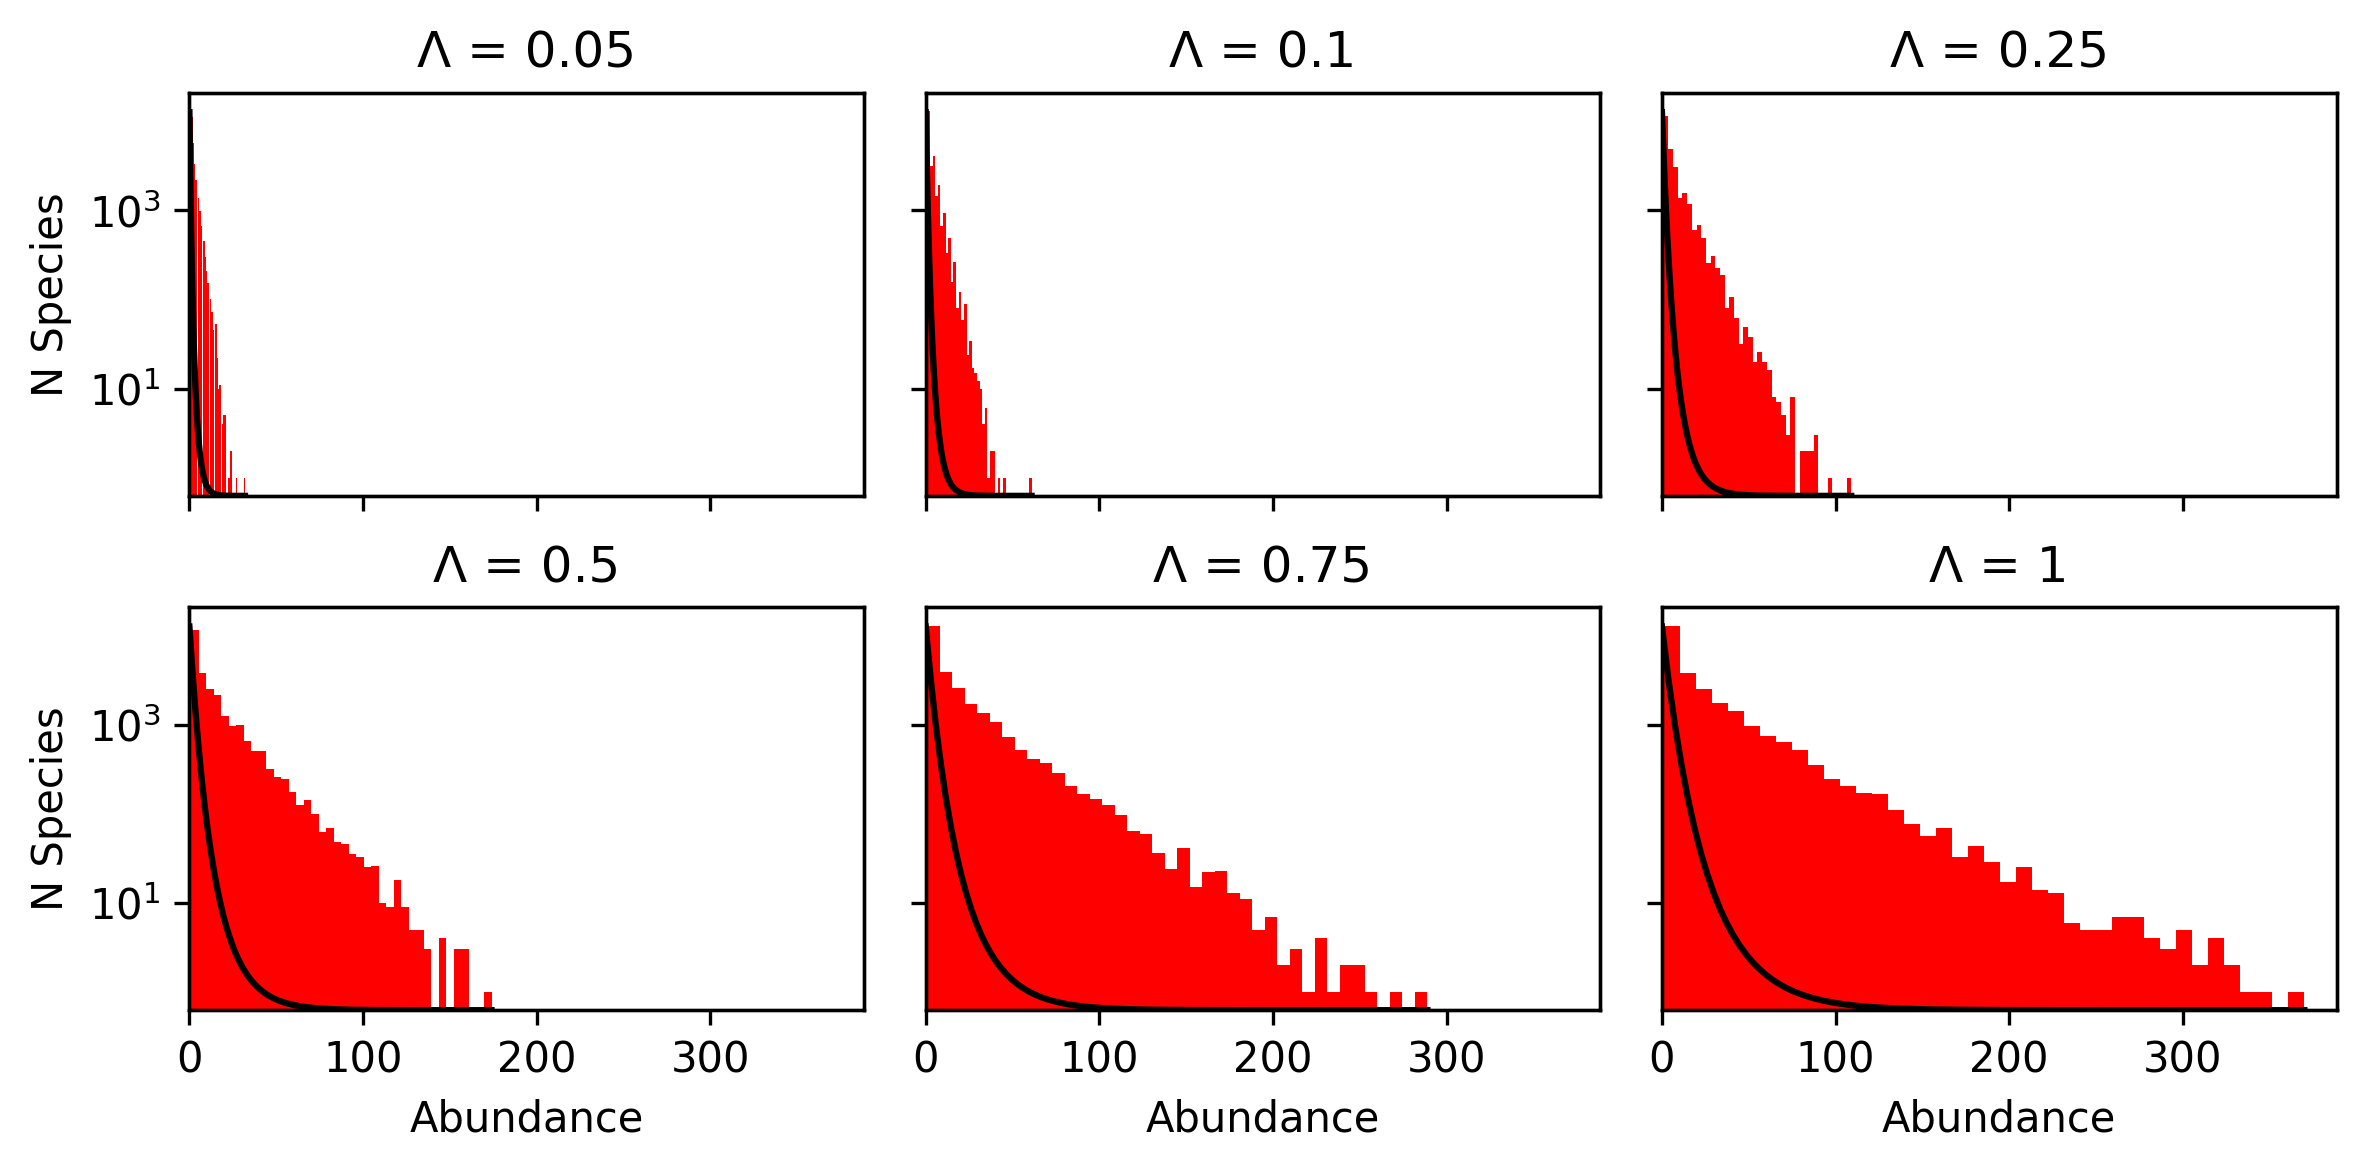

In [413]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[1:])
    lambda_dists[percent] = coltimes[:27000]
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),
print("\n")
## Plot
plot_pidxy_per_lambda(lambda_dists, "Abundance", nbins=40, normed=False, zoom_x=1, \
                      sharex=True, sharey=True, semilogx=False, semilogy=True, do_expon=True)

# Do pi and Dxy
## Gather all the pi and dxy values vectors for all the simulations

In [525]:
files = glob.glob(SIMOUT_DIR + "*5000*/pidxy.txt")
pi_dat = []
dxy_dat = []
for f in files:
    lines = open(f).readlines()
    tmp_pi = []
    tmp_dxy = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            ldat = line.strip().split()
            l = [float(ldat[0])] + [float(x.translate(None, "[],")) for x in ldat[2:]]
            if "pi" in ldat:
                tmp_pi.append(l)
            else:
                tmp_dxy.append(l)
        except Exception as inst:
            print(inst)
    pi_dat.extend(tmp_pi)
    dxy_dat.extend(tmp_dxy)
print("Processed ntimepoints {} {}".format(len(pi_dat), len(dxy_dat)))
#print(dxy_dat[:1])


Processed ntimepoints 60871 60871


## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

Got n coltimes per lambda:
0.25 - 470610	0.5 - 806199	0.05 - 224335	0.1 - 278887	1 - 1963708	0.75 - 845822	

0.05 8.19132627031e-05
0.1 0.000114725087913
0.25 0.000166794464465
0.5 0.000226137196026
0.75 0.000264686556049
1 0.000297723524644
Got n coltimes per lambda:
0.25 - 470610	0.5 - 806199	0.05 - 224335	0.1 - 278887	1 - 1963708	0.75 - 845822	

0.05 0.0042706433443
0.1 0.00412470053552
0.25 0.00399737304162
0.5 0.0039366366864
0.75 0.00392753560174
1 0.00394694172815


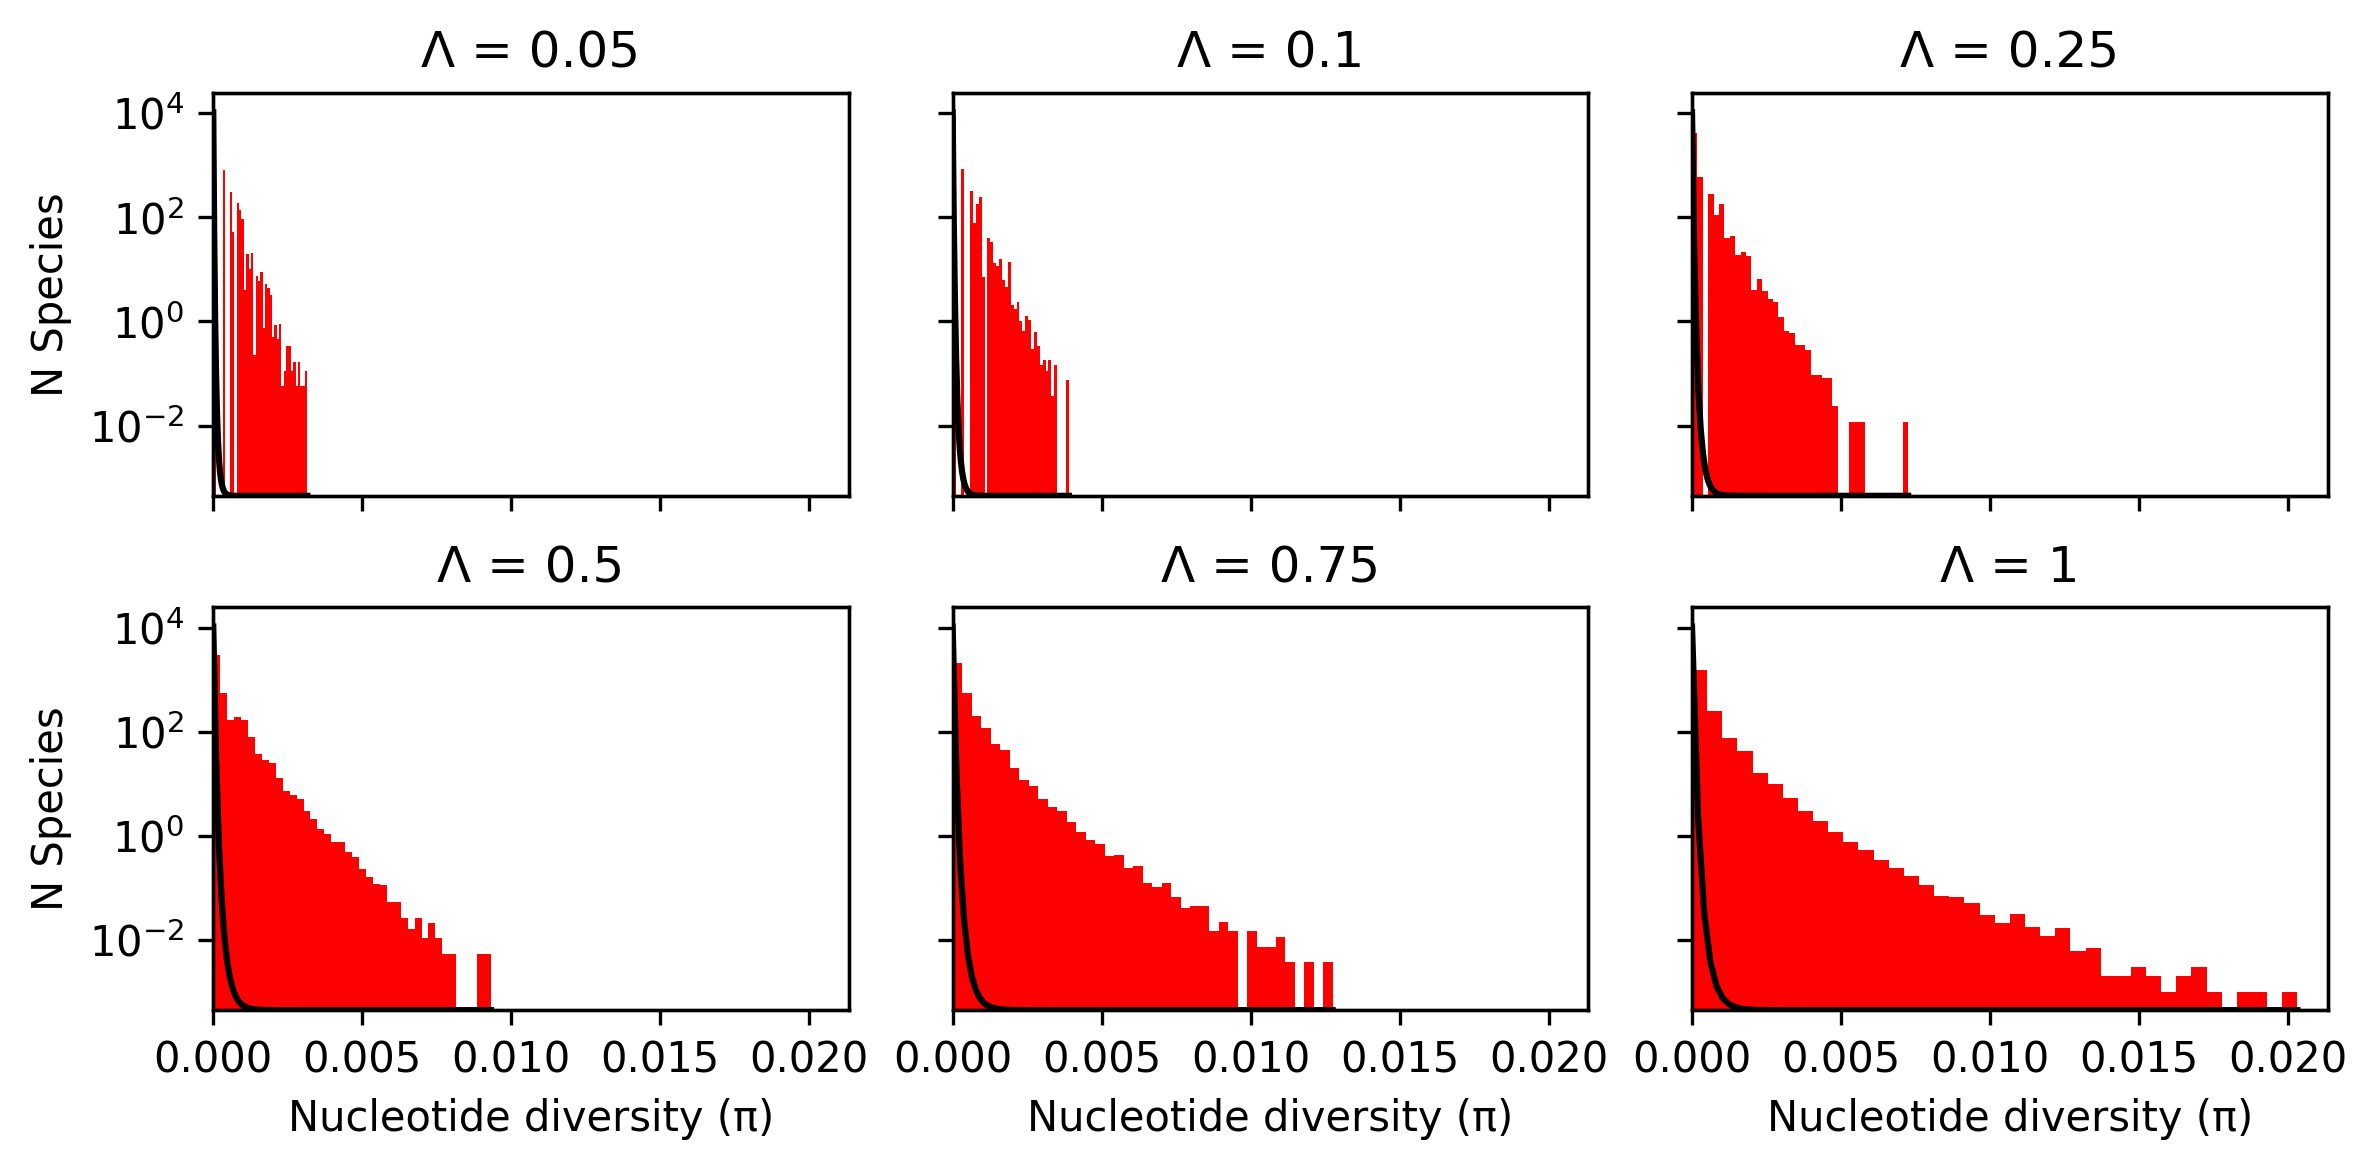

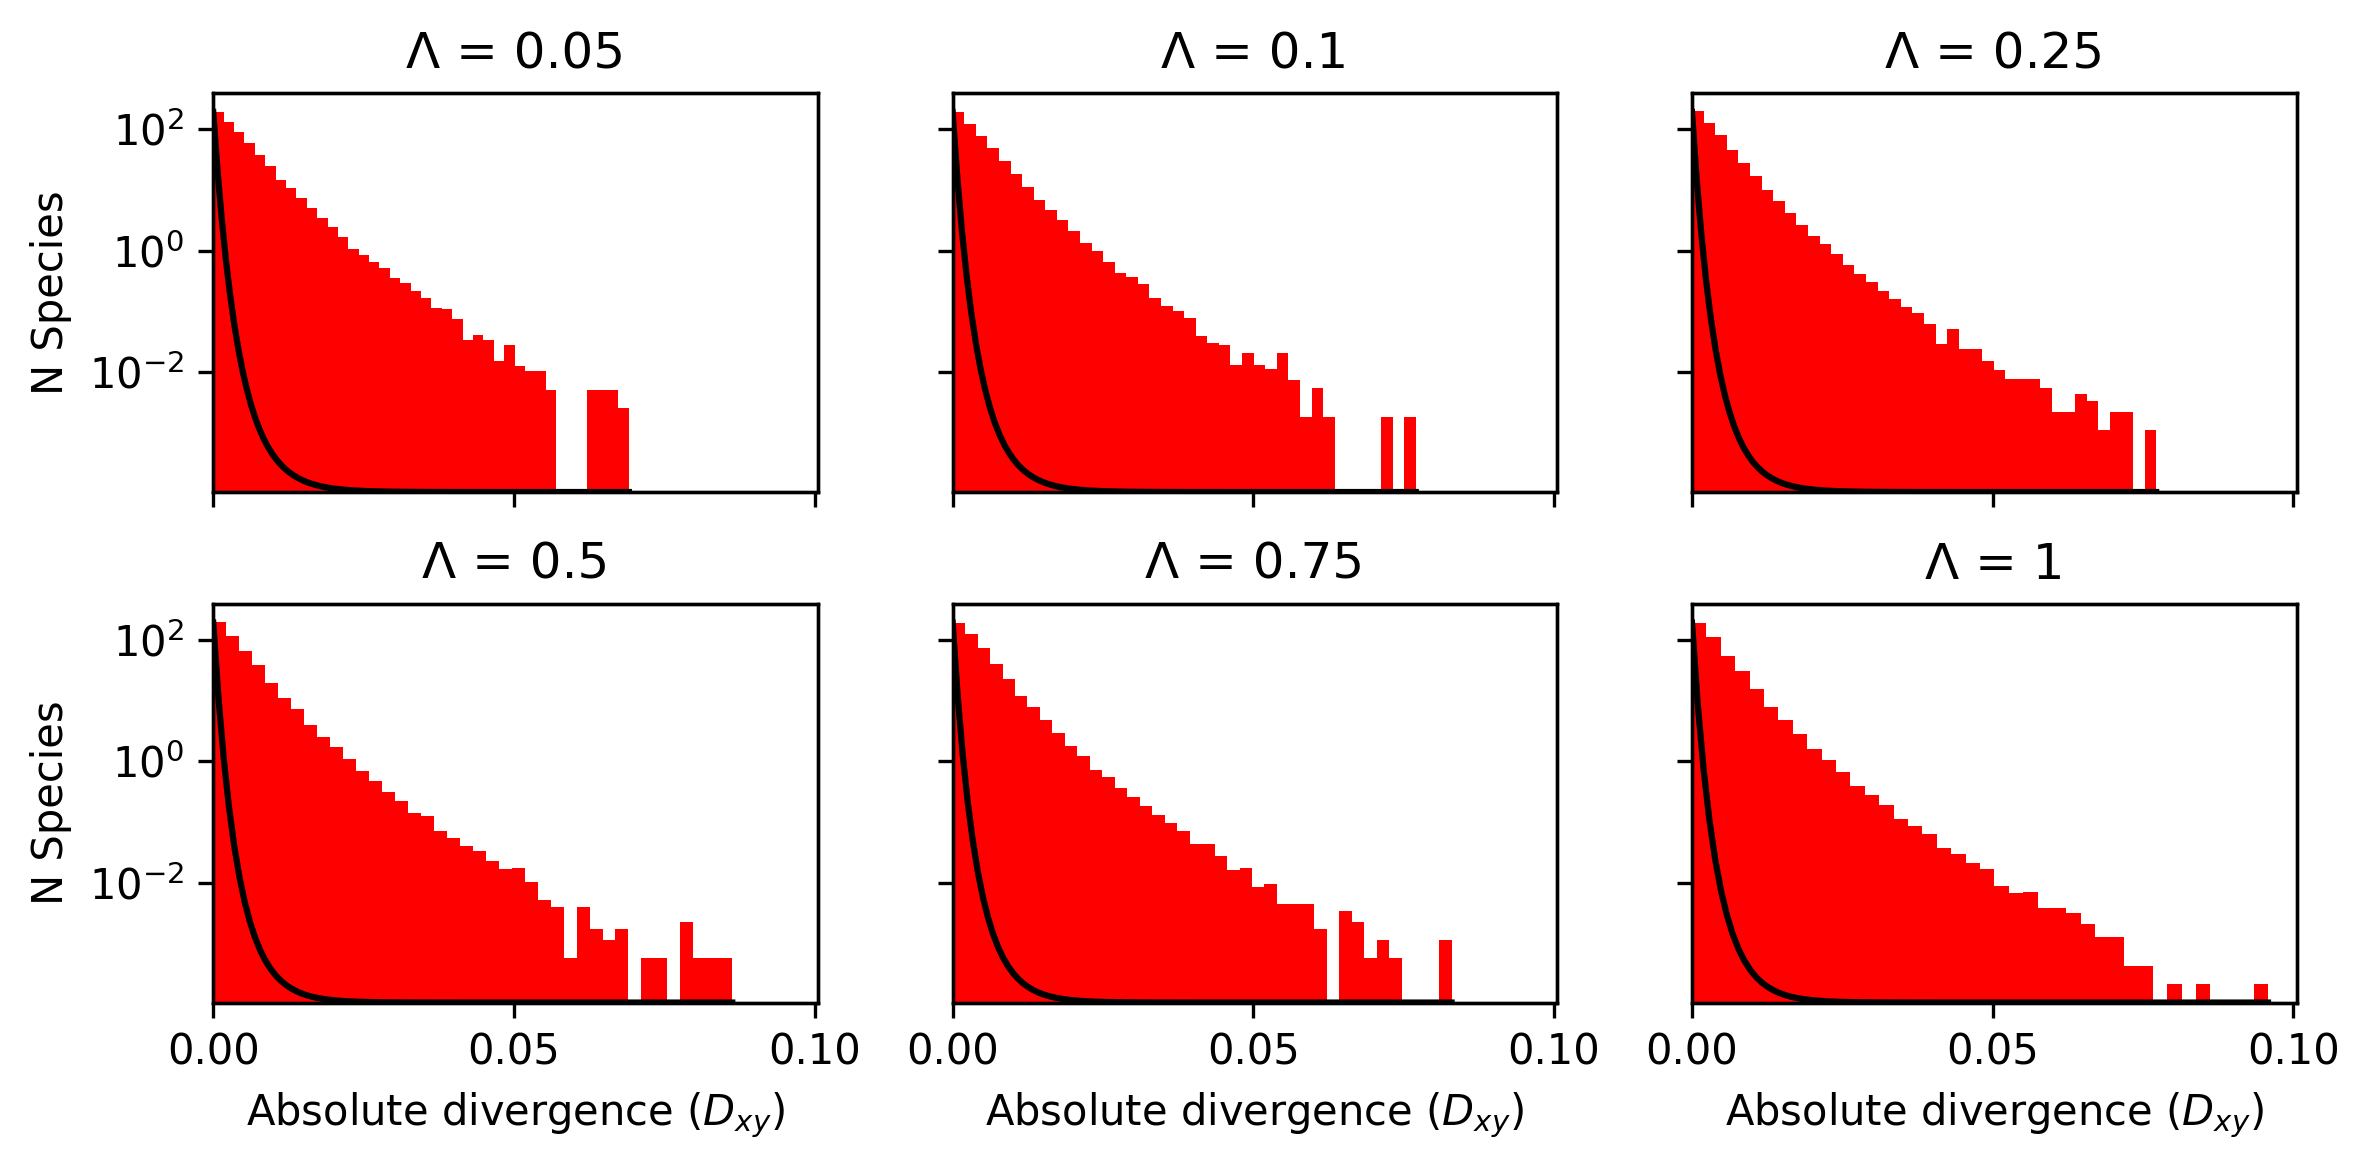

In [527]:
time_tolerance = 0.03
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
    lambda_dists = {perc:[] for perc in sampling_lambdas}
    ## Ineffecient but i don't care
    for percent in sampling_lambdas:
        coltimes = []
        for line in dat:
            ## If the difference between the lambda for each line
            ## is close enough to the sampling lambda we want then keep the coltimes
            if abs(line[0] - percent) < time_tolerance:
                m = np.array(line[2:])
                p = m[m<0.2]
                p = p[p>=0]
                coltimes.extend(p)
        lambda_dists[percent] = coltimes#[:100000]
        #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
    print("Got n coltimes per lambda:")
    for k,v in lambda_dists.items():
        print("{} - {}\t".format(k, len(v))),
    print("\n")
    ## Plot
    if "pi" in g:
        plot_pidxy_per_lambda(lambda_dists, u"Nucleotide diversity (π)", nbins=40, normed=True, sharey=True, \
                              zoom_x=1, semilogx=False, semilogy=True)
    else:
        plot_pidxy_per_lambda(lambda_dists, r"Absolute divergence ($D_{xy}$)", nbins=40, normed=True, sharey=True, \
                              zoom_x=1, semilogx=False, semilogy=True)

In [472]:
tot = 0
for p in dxy_dat:
    tot += len(p)
print(tot)

669171


## Testing plotting shannon's on binned pi x dxy

Got n coltimes per lambda:
0.25 - 275	0.5 - 275	0.05 - 275	0.1 - 275	1 - 275	0.75 - 275	

median
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
iqr
(0.0, 0.00035087719298245617)
(0.0, 0.00035087719298245617)
(0.0, 0.00035087719298245617)
(0.0, 0.00062378167641325539)
(0.0, 0.00062378167641325539)
(0.00035087719298245617, 0.00062378167641325539)
mean
(2.6910935154996641e-05, 0.0002564023226791258)
(4.1910331384015596e-05, 0.00026785443747538105)
(5.288583778286296e-05, 0.00029031234416791333)
(0.00012166431404180952, 0.00039259623617715107)
(0.00015497076023391812, 0.00039384881957981377)
(0.00016548638356322123, 0.00043388564002599093)
std
(0.00012448862559218043, 0.00052390421993071964)
(0.00016107251518559192, 0.00055389297574760918)
(0.00016170328891275854, 0.00061581904346904995)
(0.00027281589380219375, 0.00092464174326089123)
(0.00033217283709374208, 0.0010288022889884823)
(0.00033981296405596596, 0.0010288022889884823)
skew
(1.7183829284134147, 5.5632390636566

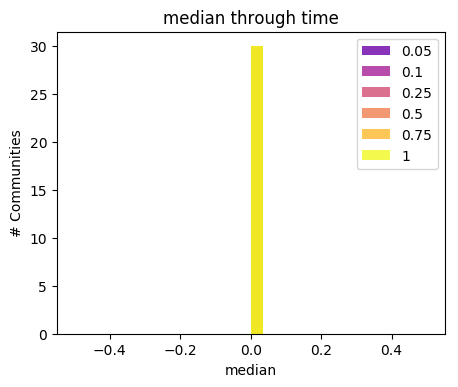

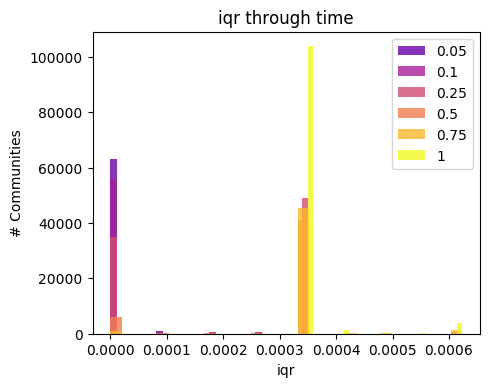

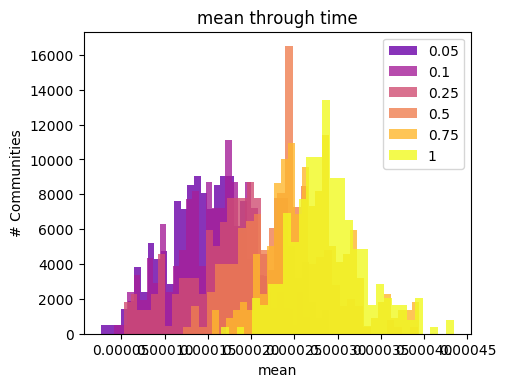

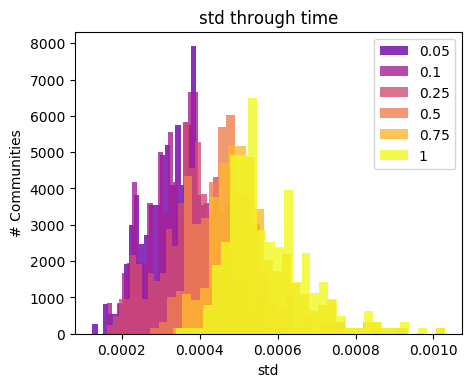

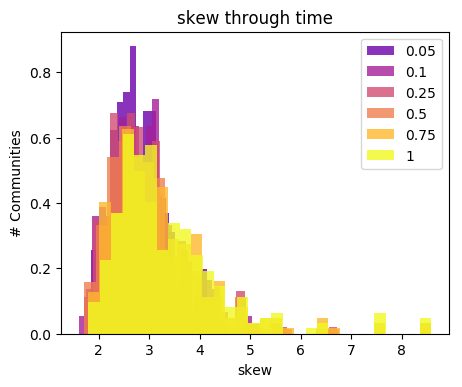

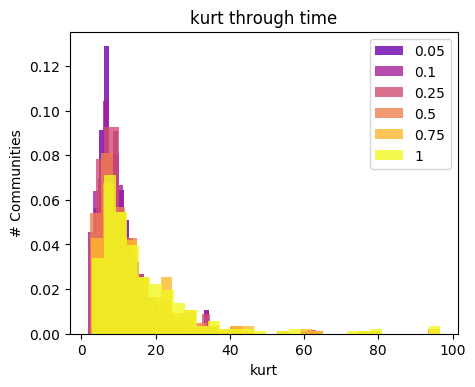

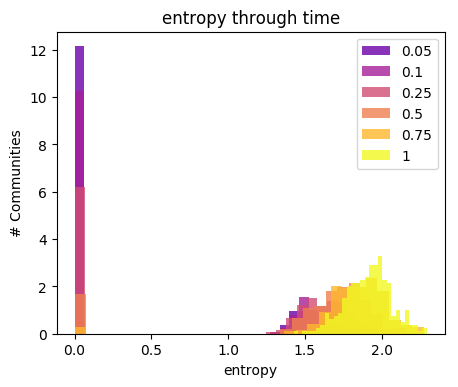

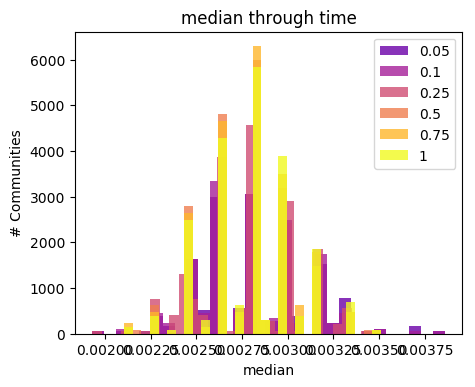

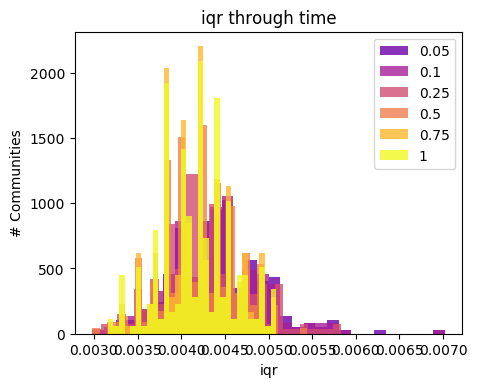

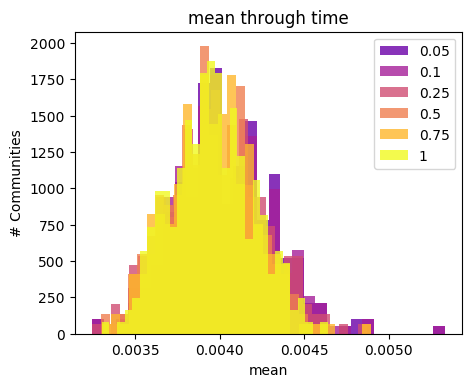

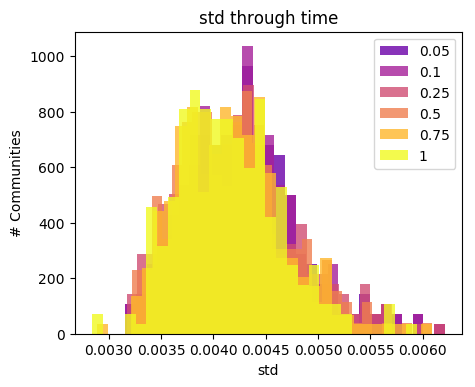

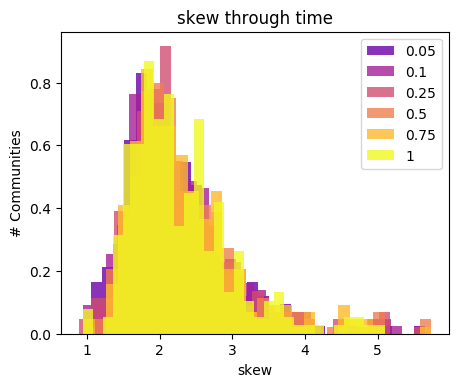

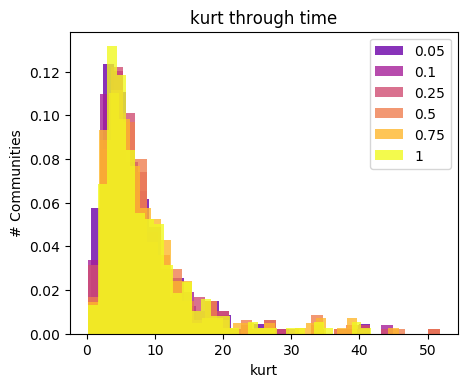

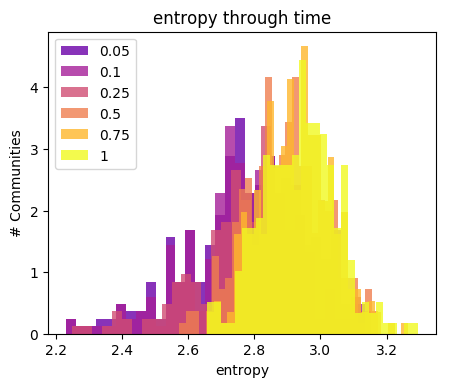

In [524]:
time_tolerance = 0.3
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

def shan(vec):
    hist, edges = np.histogram(vec, bins="auto")
    entropy = 0
    tot = sum(hist)
    for b in hist:
        if b > 0:
            p_x = float(b)/tot
            entropy += - p_x*math.log(p_x, 2)
    return entropy

def plot_pi_dxy_H(lambda_dists):
    ## Calculate shanon's for each sampled community within each timepoint
    
    for label, func in zip(["median", "iqr", "mean", "std", "skew", "kurt", "entropy"], \
                           [np.median, scipy.stats.iqr, np.mean, np.std, scipy.stats.skew, scipy.stats.kurtosis, shan]):
        print(label)
        f, ax = plt.subplots(1, figsize=(5,4), dpi=100)
        ## Set up the colors
        gradient = np.linspace(0.2, 1, 6)
        #cm = plt.cm.get_cmap('plasma')
        cm = plt.cm.get_cmap('plasma')
        for i,l in enumerate(sampling_lambdas):
            dat = [func(x) for x in lambda_dists[l]]
            print(min(dat), max(dat))
            try:
                ax.hist(dat, normed=True, label=[l], color=cm(gradient[i], alpha=0.8), bins=30)
            except:
                pass
            ax.legend()
            ax.set_xlabel(label)
            ax.set_ylabel("# Communities")
            ax.set_title("{} through time".format(label))

########################################

## Dict for storing distributions per timepoint
for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
    lambda_dists = {perc:[] for perc in sampling_lambdas}
    ## Ineffecient but i don't care
    for percent in sampling_lambdas:
        coltimes = []
        for line in dat:
            if len(line) < 10:
                ## bad data
                continue
            ## If the difference between the lambda for each line
            ## is close enough to the sampling lambda we want then keep the coltimes
            if abs(line[0] - percent) < time_tolerance:
                m = np.array(line[2:])
                p = m[m<0.06]
                coltimes.append(p)
        lambda_dists[percent] = coltimes[:275]
        #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
    print("Got n coltimes per lambda:")
    for k,v in lambda_dists.items():
        print("{} - {}\t".format(k, len(v))),
    print("\n")
    ## Plot
    if "pi" in g:
        plot_pi_dxy_H(lambda_dists)
    else:
        plot_pi_dxy_H(lambda_dists)

In [277]:
import math
def shan(hist):
    entropy = 0
    tot = sum(hist)
    for b in hist:
        if b > 0:
            p_x = float(b)/tot
            entropy += - p_x*math.log(p_x, 2)
    return entropy
            
tmp = lambda_dists[0.25][10]
bins, edges = np.histogram(tmp, bins=30)

print(shan(bins))
print(bins)
print(edges)

2.77412055701
[60 39 29 11  4  6 10  7  2  3  0  2  1  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  1]
[ 0.          0.00154386  0.00308772  0.00463158  0.00617544  0.0077193
  0.00926316  0.01080702  0.01235088  0.01389474  0.0154386   0.01698246
  0.01852632  0.02007018  0.02161404  0.02315789  0.02470175  0.02624561
  0.02778947  0.02933333  0.03087719  0.03242105  0.03396491  0.03550877
  0.03705263  0.03859649  0.04014035  0.04168421  0.04322807  0.04477193
  0.04631579]


# **Shannon**
## Grab all the data from the sumstats file

In [67]:
files = glob.glob(SIMOUT_DIR + "*5000*/sumstats.txt")
dat = []
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            d = [float(x) for x in line.strip().split()]
            ## 3 - lambda
            ## 4/5 - col/ext rates
            ## 6 - Shannon
            l = d[3:7]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))
print(dat[:1])

Processed ntimepoints 13569
[[0.0594, 0.0292, 0.0069, 1.84025222471]]


Got n coltimes per lambda:
0.25 - 101	0.5 - 44	0.05 - 324	0.1 - 192	1 - 7685	0.75 - 41	

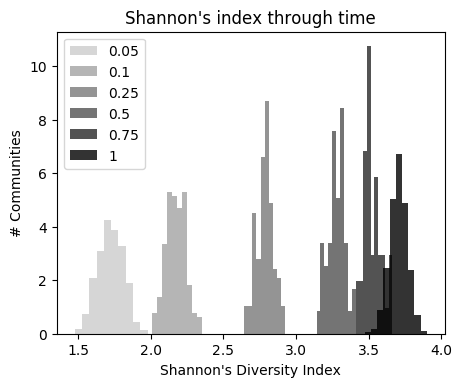

In [149]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend([line[3]])
    lambda_dists[percent] = coltimes
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),

## Plot
f, ax = plt.subplots(1, figsize=(5,4), dpi=100)
## Set up the colors
gradient = np.linspace(0.2, 1, 6)
#cm = plt.cm.get_cmap('plasma')
cm = plt.cm.get_cmap('binary')
for i,l in enumerate(sampling_lambdas):
    ax.hist(lambda_dists[l], normed=True, label=[l], color=cm(gradient[i], alpha=0.8))
    ax.legend()
    ax.set_xlabel("Shannon's Diversity Index")
    ax.set_ylabel("# Communities")
    ax.set_title("Shannon's index through time")

# Extinction rate

Got n coltimes per lambda:
0.25 - 101	0.5 - 44	0.05 - 324	0.1 - 192	1 - 7685	0.75 - 41	

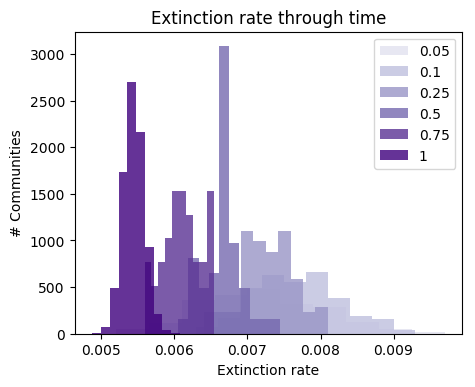

In [181]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            #print(line)
            #coltimes.extend([line[1] - line[2]])
            coltimes.extend([line[2]])
    lambda_dists[percent] = coltimes
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)

print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),

## Plot
f, ax = plt.subplots(1, figsize=(5,4), dpi=100)
## Set up the colors
gradient = np.linspace(0.2, 1, 6)
#cm = plt.cm.get_cmap('plasma')
cm = plt.cm.get_cmap('Purples')
for i,l in enumerate(sampling_lambdas):
    ax.hist(lambda_dists[l], normed=True, bins=10, label=[l], color=cm(gradient[i], alpha=0.8))
    ax.legend()
    ax.set_xlabel("Extinction rate")
    ax.set_ylabel("# Communities")
    ax.set_title("Extinction rate through time")

# Crap below here

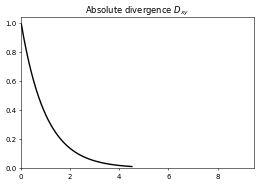

In [109]:
f, ax = plt.subplots(1,1, figsize=(6,4), dpi=50)
x = np.arange(expon.ppf(0.01), expon.ppf(0.99), .1)
rv = expon()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_xlim(0,x1*2)
ax.set_ylim(0,y1)
## Works
#ax.spines['left'].set_position(('axes', 0.03))
#ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position(('axes', 0.04))
#ax.spines['top'].set_color('none')
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
ax.set_title(r"Absolute divergence $D_{xy}$")

In [12]:
np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5))

array([      1,  500000,  999999, 1499998, 1999997, 2499996])

In [ ]:
plot_pidxy_per_lambda(lambda_dists, "Average pairwise distance", nbins=100)

AttributeError: Unknown property density

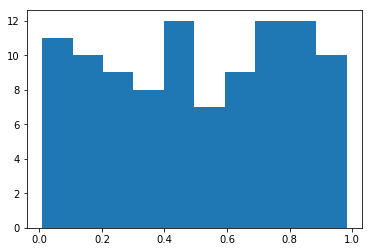

In [49]:
ax = plt.subplot(111)
ax.hist(np.random.uniform(0,1,100), )

# Salvage the files that had double equilibrium resetting lambda to zero.

In [435]:
## Clean the simulations
workdir = "/home/isaac/gimmeSAD/deme_size_sims/"
files = ["abundances.txt", "coltimes.txt", "pidxy.txt"]

for f in files:
    print("Doing {}".format(f))
    allf = glob.glob(workdir+"*/"+f)
    print("Numfiles {}".format(len(allf)))
    for tmpfile in allf:
            print(tmpfile)
            out = []
            lines = open(tmpfile).readlines()
            lamb = 0
            for line in lines:
                if abs(float(line.split()[0]) - lamb) < 0.7:
                    lamb = float(line.split()[0])
                    out.append(line)
                else:
                    out.append("1 "+ line.split(" ", 1)[1])
                    break
            with open(tmpfile, 'w') as outfile:
                outfile.write("".join(out))


Doing abundances.txt
Numfiles 216
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831849.15_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509733441.1_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915102.72_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733440.98_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733430.27_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915105.76_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509915102.74_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509831846.35_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917687.97_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509831846.29_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831848.61_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-15098

/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509915105.82_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733440.95_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733441.27_x4/abundances.txt
Doing coltimes.txt
Numfiles 216
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831849.15_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509733441.1_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915102.72_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733440.98_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733430.27_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915105.76_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509915102.74_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509831846.35_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917687.97_x4/coltim

/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509831846.34_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509915102.73_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509917687.98_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733441.6_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509915102.74_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917691.68_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509831848.63_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509917687.97_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509733430.34_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509733430.22_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509831848.64_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733430.24_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_si

/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831848.61_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509831849.12_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509915105.58_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509733441.65_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509915105.58_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509915102.74_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509733430.61_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831846.1_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509733430.31_x4/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509917691.41_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509733441.17_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509917691.42_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509733441.55

/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831849.05_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509831846.13_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733430.19_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509733430.44_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509917691.62_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509915105.79_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509733441.7_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509733430.21_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831846.35_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509915102.71_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509831846.25_x4/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831848.92_x4/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917691.51_x